In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
 
from itertools import product
from tqdm import tqdm_notebook

import Model_Evaluation as me

In [2]:
books = pd.read_csv('/Users/rahulnair/Desktop/Labelmaster_/Sales_Data/Books_ext_fs.csv')
#books = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LabelMaster/LabelMaster Data/Books_ext.csv')
sales = books[['Year_Month','Sum of Sales']]
sales

,Year_Month,Sum of Sales
0,2008-01,282604.11
1,2008-02,262474.40
2,2008-03,326059.68
3,2008-04,215387.49
4,2008-05,499559.90
...,...,...
150,2020-07,150348.10
151,2020-08,156066.95
152,2020-09,468710.96
153,2020-10,1118446.80


In [3]:
books = books.dropna(axis = 1)
exog = books.iloc[:,2:]
exog

,"FTR Truck Loadings (000s, SA)_freight_m_trucking","FTR Active Truck Utilization (%, SA)_freight_m_trucking","Reefer Trailer Loadings (000s, SA)_freight_m_trucking","Tank Trailer Loadings (000s, SA)_freight_m_trucking","Chemicals & Allied Products (000s, SA)_freight_m_trucking",Spot TL Rates (w/o FSC)_rates_m_trucking,Total LTL (w/o FSC)_rates_m_trucking,Total LTL (w/ FSC)_rates_m_trucking,Contract TL Tank Rates (w/o FSC)_rates_m_trucking,"OEM Net Orders (U.S. / CAN, units)_indicators_m_trucking",...,BUILD FOR_All_Other,Change in Distillate Fuel Inventories_x,Intermodal Revenue Movements (IANA-ETSO)_Total_x,FTR Intermodal Competitive Index_Intermodal Competitive Index (0=Neutral)_x,U.S. Origin Intermodal Volumes_International_x,Canada Origin Intermodal Volumes_Domestic_x,"N.A. Port Activity, Total TEUs_Exports_x","West Coast Port Activity, Total TEUs_Exports_x","Gulf Coast Port Activity, Total TEUs_Exports_x","Western Canadian Port Activity, Total TEUs_Exports_x"
0,57633.608984,88.294650,3940.638792,6915.782704,3013.868684,96.932289,99.755501,114.408275,99.995901,16185.0,...,969.0,-2981.0,1156094.0,3.341993,557011.0,46969.0,1.035742e+06,428531.270000,90322.590000,70230.000000
1,57175.659828,87.998407,3927.115595,6836.939472,2975.285847,99.719858,99.755501,114.867841,100.276486,11091.0,...,1104.0,-13327.0,1088826.0,2.285576,501961.0,44924.0,1.138045e+06,478707.330000,100410.660000,86567.000000
2,56814.700553,87.790155,3922.853376,6758.129439,2941.079313,103.347853,100.488998,117.070858,99.727612,14647.0,...,1158.0,-9852.0,1082825.0,1.924076,481100.0,46727.0,1.167742e+06,500866.450000,93384.280000,80451.000000
3,56916.813852,89.639867,3978.633479,6858.428982,2906.591249,111.718085,101.589242,122.811123,99.057287,14264.0,...,931.0,-733.0,1158286.0,5.986521,528843.0,53497.0,1.156788e+06,486063.840000,101642.940000,84739.000000
4,56194.246889,89.134818,3990.692209,6804.610846,2872.185063,117.525703,101.314181,123.968232,97.828232,12060.0,...,991.0,6890.0,1184144.0,7.940801,541259.0,53653.0,1.185090e+06,490618.980000,105424.640000,89548.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,61469.059874,89.962431,4379.187334,6571.127779,2639.040651,115.128696,102.231051,113.578198,115.191063,19213.0,...,1359.0,2134.0,1526490.0,-0.192121,513074.0,57503.0,1.095134e+06,393775.832112,125276.157772,103172.000000
151,62140.797176,90.641835,4404.415547,6601.260917,2676.666422,129.107598,104.339853,115.812566,114.911925,18302.0,...,1671.0,1353.0,1575928.0,0.625716,546740.0,56478.0,1.108304e+06,389408.103791,125319.157772,93979.000000
152,62170.174317,90.587889,4381.188114,6556.745680,2600.808117,136.100117,105.898533,117.464895,115.470202,28766.0,...,1711.0,-7196.0,1617044.0,5.475578,557748.0,59269.0,1.099329e+06,386298.700253,117576.128306,103129.000000
153,62870.759335,94.367218,4436.920215,6523.796564,2593.200335,140.122763,106.265281,117.793788,115.098017,36912.0,...,2018.0,-10130.4,1705714.0,9.817290,591616.0,60708.0,1.186353e+06,410614.677268,123604.184721,105255.000000


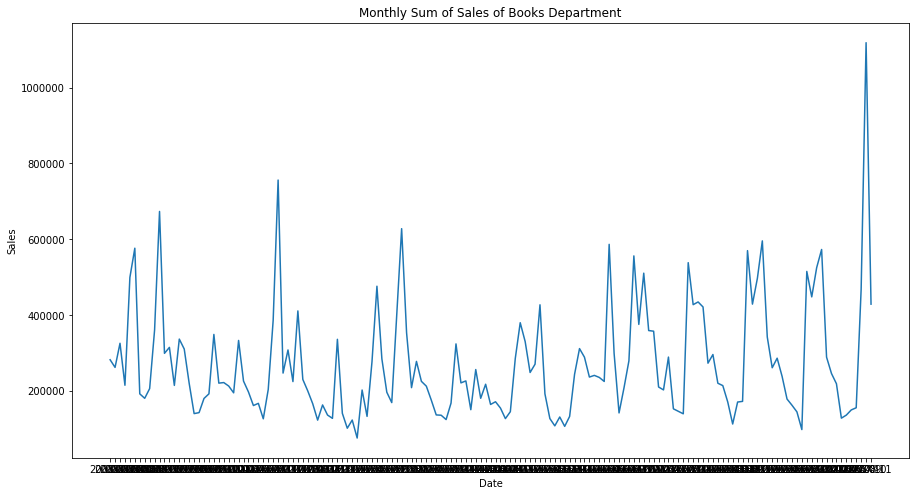

In [4]:
plt.figure(figsize=[15,8])
plt.plot(sales['Year_Month'],sales['Sum of Sales'])
plt.title('Monthly Sum of Sales of Books Department')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [5]:
ad_fuller_result = adfuller(sales['Sum of Sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.5489088668534055
p-value: 0.10402307648031173


Since the p-value is greater than 0.5, we cannot reject null hypothesis and must assume that the series is not stationary.

In [6]:
sales['sales_diffed'] = sales['Sum of Sales'].diff(1)
sales

,Year_Month,Sum of Sales,sales_diffed
0,2008-01,282604.11,NaN
1,2008-02,262474.40,-20129.71
2,2008-03,326059.68,63585.28
3,2008-04,215387.49,-110672.19
4,2008-05,499559.90,284172.41
...,...,...,...
150,2020-07,150348.10,13635.82
151,2020-08,156066.95,5718.85
152,2020-09,468710.96,312644.01
153,2020-10,1118446.80,649735.84


In [7]:
ad_fuller_result = adfuller(sales['sales_diffed'][1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.7998057140649335
p-value: 4.659551329185685e-07


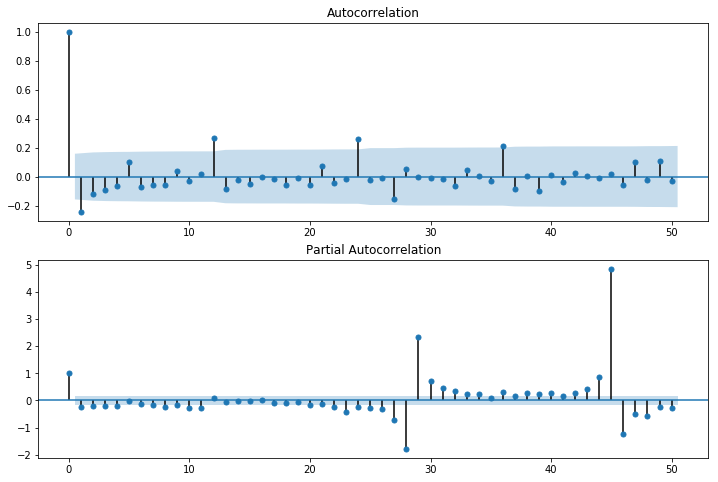

In [8]:
fig, ax = plt.subplots(2,1, figsize= (12,8))
fig = sm.graphics.tsa.plot_acf(sales['sales_diffed'][1:], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(sales['sales_diffed'][1:], lags=50, ax=ax[1])
plt.show()

# New Section

In [9]:
p = range(0,4)
d = range(1,2)
q = range(0,4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

df = pd.DataFrame()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales['Sum of Sales'],
                                            exog = exog,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}- AIC:{}'.format(param, param_seasonal, results.aic))

            combo = [(param,param_seasonal,results.aic)]
            df = df.append(combo)
            print(" ")
        except:
            continue
df.columns = ['param','param_seasonal', 'AIC']

ARIMA(0, 1, 0)x(0, 1, 0, 12)- AIC:4373.94937859835
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)- AIC:3508.390518308127
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 2, 12)- AIC:3193.336859696294
 
ARIMA(0, 1, 0)x(0, 1, 3, 12)- AIC:9485.060658740067
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 12)- AIC:3533.4398333618865
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)- AIC:3509.806261006779
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 2, 12)- AIC:3195.3357456100093
 
ARIMA(0, 1, 0)x(1, 1, 3, 12)- AIC:9495.564982244234
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 1, 0, 12)- AIC:3216.5859952055166
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 1, 1, 12)- AIC:3217.7645355141776
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 1, 2, 12)- AIC:3195.1987094332458
 
ARIMA(0, 1, 0)x(2, 1, 3, 12)- AIC:9484.933662167105
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(3, 1, 0, 12)- AIC:2904.150789445545
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(3, 1, 1, 12)- AIC:2906.4109642620633
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(3, 1, 2, 12)- AIC:2904.139129381426
 
ARIMA(0, 1, 0)x(3, 1, 3, 12)- AIC:9426.851384028776
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)- AIC:3789.2028860990386
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)- AIC:3482.281695683303
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 2, 12)- AIC:3168.740528486076
 
ARIMA(0, 1, 1)x(0, 1, 3, 12)- AIC:9390.207917233227
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)- AIC:3533.5062322091967
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)- AIC:3484.5507657438357
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 2, 12)- AIC:3170.8213167921735
 
ARIMA(0, 1, 1)x(1, 1, 3, 12)- AIC:9400.378277081927
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 12)- AIC:3218.718505148934
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 1, 12)- AIC:3219.9580520265736
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 2, 12)- AIC:3170.673374875312
 
ARIMA(0, 1, 1)x(2, 1, 3, 12)- AIC:9384.654996276335
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(3, 1, 0, 12)- AIC:2906.1425693851315
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(3, 1, 1, 12)- AIC:2908.373601106715
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(3, 1, 2, 12)- AIC:2905.2979678576608
 
ARIMA(0, 1, 1)x(3, 1, 3, 12)- AIC:9338.336770486309
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(0, 1, 0, 12)- AIC:3765.2367840580773
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(0, 1, 1, 12)- AIC:3456.222635493016
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(0, 1, 2, 12)- AIC:3144.6644745677822
 
ARIMA(0, 1, 2)x(0, 1, 3, 12)- AIC:9302.199689936551
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 0, 12)- AIC:3533.2261727760765
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 1, 12)- AIC:3458.3031341931546
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 2, 12)- AIC:3146.6345947431414
 
ARIMA(0, 1, 2)x(1, 1, 3, 12)- AIC:9312.29148863286
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 12)- AIC:3220.884217943499
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 1, 12)- AIC:3222.103117672883
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 2, 12)- AIC:3145.641084272716
 
ARIMA(0, 1, 2)x(2, 1, 3, 12)- AIC:9296.738623988864
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(3, 1, 0, 12)- AIC:2906.188469529572
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(3, 1, 1, 12)- AIC:2908.5054923143
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(3, 1, 2, 12)- AIC:2907.557900970513
 
ARIMA(0, 1, 2)x(3, 1, 3, 12)- AIC:9250.884996523488
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(0, 1, 0, 12)- AIC:3737.43872072418
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(0, 1, 1, 12)- AIC:3428.0212665492486
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(0, 1, 2, 12)- AIC:3120.4282458854213
 
ARIMA(0, 1, 3)x(0, 1, 3, 12)- AIC:9217.676410485072
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(1, 1, 0, 12)- AIC:3535.2365046423824
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(1, 1, 1, 12)- AIC:3429.7450215525346
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(1, 1, 2, 12)- AIC:3121.8734073080373
 
ARIMA(0, 1, 3)x(1, 1, 3, 12)- AIC:9227.689648028989
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(2, 1, 0, 12)- AIC:3222.7245228502948
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(2, 1, 1, 12)- AIC:3223.7730361671465
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(2, 1, 2, 12)- AIC:3119.432579962586
 
ARIMA(0, 1, 3)x(2, 1, 3, 12)- AIC:9212.307199546582
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(3, 1, 0, 12)- AIC:2906.039420752062
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(3, 1, 1, 12)- AIC:2908.50092341347
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(3, 1, 2, 12)- AIC:2908.7827646542983
 
ARIMA(0, 1, 3)x(3, 1, 3, 12)- AIC:9166.918170405994
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 12)- AIC:3816.8128075430973
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)- AIC:3508.8170357096747
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 2, 12)- AIC:3194.848300914777
 
ARIMA(1, 1, 0)x(0, 1, 3, 12)- AIC:9479.441349250461
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)- AIC:3508.7668765980143
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)- AIC:3511.198657064371
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 2, 12)- AIC:3196.810473577735
 
ARIMA(1, 1, 0)x(1, 1, 3, 12)- AIC:9489.69027025155
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 0, 12)- AIC:3193.3308772698047
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 1, 12)- AIC:3194.738659523612
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 2, 12)- AIC:3196.9409844601673
 
ARIMA(1, 1, 0)x(2, 1, 3, 12)- AIC:9473.796573284371
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(3, 1, 0, 12)- AIC:2880.68301420825
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(3, 1, 1, 12)- AIC:2882.8632124509077
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(3, 1, 2, 12)- AIC:2880.3391274127207
 
ARIMA(1, 1, 0)x(3, 1, 3, 12)- AIC:9427.013749169155
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)- AIC:3790.779422875181
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)- AIC:3482.8204657982187
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 2, 12)- AIC:3170.26569784188
 
ARIMA(1, 1, 1)x(0, 1, 3, 12)- AIC:9391.740087706501
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)- AIC:3508.2510783319203
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)- AIC:3484.9804273822197
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 2, 12)- AIC:3169.5964475123883
 
ARIMA(1, 1, 1)x(1, 1, 3, 12)- AIC:9401.9104475552
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 12)- AIC:3194.052794432143
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 1, 12)- AIC:3195.92264903597
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 2, 12)- AIC:3171.0996623456576
 
ARIMA(1, 1, 1)x(2, 1, 3, 12)- AIC:9386.187166749613
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 0, 12)- AIC:2880.743804985049
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 1, 12)- AIC:2882.8299346072317
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 2, 12)- AIC:2882.1272979644077
 
ARIMA(1, 1, 1)x(3, 1, 3, 12)- AIC:9339.868940959746
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(0, 1, 0, 12)- AIC:3767.1302554145877
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 12)- AIC:3458.2112782078357
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(0, 1, 2, 12)- AIC:3146.809612294871
 
ARIMA(1, 1, 2)x(0, 1, 3, 12)- AIC:9304.123290931224
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 0, 12)- AIC:3509.9047313374986
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 12)- AIC:3460.4998537440565
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 2, 12)- AIC:3145.6130952222975
 
ARIMA(1, 1, 2)x(1, 1, 3, 12)- AIC:9314.215089627538
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 12)- AIC:3196.1376522529545
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 1, 12)- AIC:3198.676728026316
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 2, 12)- AIC:3147.0322737289516
 
ARIMA(1, 1, 2)x(2, 1, 3, 12)- AIC:9298.662224983538
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 0, 12)- AIC:2879.7866172741706
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 1, 12)- AIC:2881.7996052324756
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 2, 12)- AIC:2884.506935590565
 
ARIMA(1, 1, 2)x(3, 1, 3, 12)- AIC:9252.808597518148
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(0, 1, 0, 12)- AIC:3739.184854878086
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(0, 1, 1, 12)- AIC:3429.7440921326415
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(0, 1, 2, 12)- AIC:3122.1494888457405
 
ARIMA(1, 1, 3)x(0, 1, 3, 12)- AIC:9219.36414815332
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(1, 1, 0, 12)- AIC:3511.8736305959874
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(1, 1, 1, 12)- AIC:3431.516624486345
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(1, 1, 2, 12)- AIC:3121.7451184829597
 
ARIMA(1, 1, 3)x(1, 1, 3, 12)- AIC:9229.377385697238
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(2, 1, 0, 12)- AIC:3198.4547128527315
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(2, 1, 1, 12)- AIC:3200.718960078896
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(2, 1, 2, 12)- AIC:3119.4766902244187
 
ARIMA(1, 1, 3)x(2, 1, 3, 12)- AIC:9213.99493721483
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(3, 1, 0, 12)- AIC:2881.370355257514
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(3, 1, 1, 12)- AIC:2883.340254421751
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(3, 1, 2, 12)- AIC:2885.43630269709
 
ARIMA(1, 1, 3)x(3, 1, 3, 12)- AIC:9168.605908074574
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(0, 1, 0, 12)- AIC:3789.9735953436093
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(0, 1, 1, 12)- AIC:3508.391820677692
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(0, 1, 2, 12)- AIC:3196.7347416980156
 
ARIMA(2, 1, 0)x(0, 1, 3, 12)- AIC:9479.802940415888
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 1, 0, 12)- AIC:3483.056019096363
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 1, 1, 12)- AIC:3485.294592559705
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 1, 2, 12)- AIC:3198.7394415748836
 
ARIMA(2, 1, 0)x(1, 1, 3, 12)- AIC:9490.051861416978
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 0, 12)- AIC:3168.5209591583753
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 12)- AIC:3169.916916754985
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 2, 12)- AIC:3171.341082136586
 
ARIMA(2, 1, 0)x(2, 1, 3, 12)- AIC:9474.1581644498
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(3, 1, 0, 12)- AIC:2856.647100947869
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(3, 1, 1, 12)- AIC:2858.8809949389442
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(3, 1, 2, 12)- AIC:2856.7031548528703
 
ARIMA(2, 1, 0)x(3, 1, 3, 12)- AIC:9339.095575189122
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(0, 1, 0, 12)- AIC:3791.2106771838467
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 12)- AIC:3484.618254303605
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(0, 1, 2, 12)- AIC:3171.8098024048886
 
ARIMA(2, 1, 1)x(0, 1, 3, 12)- AIC:9392.673286303594
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 0, 12)- AIC:3484.6200644607407
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 12)- AIC:3486.409408095485
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 2, 12)- AIC:3171.4950942429614
 
ARIMA(2, 1, 1)x(1, 1, 3, 12)- AIC:9402.843646152294
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 0, 12)- AIC:3170.5315920151206
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 12)- AIC:3171.6687753521605
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 2, 12)- AIC:3171.3242783996457
 
ARIMA(2, 1, 1)x(2, 1, 3, 12)- AIC:9387.120365346704
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 0, 12)- AIC:2853.470122349001
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 1, 12)- AIC:2855.405537871784
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 2, 12)- AIC:2858.248473762802
 
ARIMA(2, 1, 1)x(3, 1, 3, 12)- AIC:9340.802139556465
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 1, 0, 12)- AIC:3766.8593346790403
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 12)- AIC:3459.700761774641
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 1, 2, 12)- AIC:3148.814021116942
 
ARIMA(2, 1, 2)x(0, 1, 3, 12)- AIC:9305.78080920159
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 12)- AIC:3486.023076663908
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 1, 12)- AIC:3461.5400696403403
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 2, 12)- AIC:3147.5381604699787
 
ARIMA(2, 1, 2)x(1, 1, 3, 12)- AIC:9315.872607897902
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12)- AIC:3171.1687653873423
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 1, 12)- AIC:3172.4434925809624
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 2, 12)- AIC:3146.9484171647005
 
ARIMA(2, 1, 2)x(2, 1, 3, 12)- AIC:9300.319743253902
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 0, 12)- AIC:2853.605500101149
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 1, 12)- AIC:2855.6594398448206
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 2, 12)- AIC:2858.192801588845
 
ARIMA(2, 1, 2)x(3, 1, 3, 12)- AIC:9254.466115788653
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(0, 1, 0, 12)- AIC:3740.8517770381886
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(0, 1, 1, 12)- AIC:3431.1796426762758
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(0, 1, 2, 12)- AIC:3124.1880275677204
 
ARIMA(2, 1, 3)x(0, 1, 3, 12)- AIC:9221.314990379246
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(1, 1, 0, 12)- AIC:3487.863519156753
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(1, 1, 1, 12)- AIC:3431.7097139854272
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(1, 1, 2, 12)- AIC:3123.7274278122977
 
ARIMA(2, 1, 3)x(1, 1, 3, 12)- AIC:9231.328227923168
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(2, 1, 0, 12)- AIC:3172.830044319516
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(2, 1, 1, 12)- AIC:3172.1222928995785
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(2, 1, 2, 12)- AIC:3119.358140867172
 
ARIMA(2, 1, 3)x(2, 1, 3, 12)- AIC:9215.945779440759
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 0, 12)- AIC:2856.1749622336692
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 1, 12)- AIC:2857.958072693403
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 2, 12)- AIC:2860.41030946935
 
ARIMA(2, 1, 3)x(3, 1, 3, 12)- AIC:9170.556750300037
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(0, 1, 0, 12)- AIC:3765.9250215542324
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(0, 1, 1, 12)- AIC:3510.0912793991433
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(0, 1, 2, 12)- AIC:3198.846459493805
 
ARIMA(3, 1, 0)x(0, 1, 3, 12)- AIC:9481.736346211721
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(1, 1, 0, 12)- AIC:3458.4226852255815
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(1, 1, 1, 12)- AIC:3460.625101317353
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(1, 1, 2, 12)- AIC:3200.921806716728
 
ARIMA(3, 1, 0)x(1, 1, 3, 12)- AIC:9491.98526721281
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(2, 1, 0, 12)- AIC:3145.0462303395907
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(2, 1, 1, 12)- AIC:3146.369518143977
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(2, 1, 2, 12)- AIC:3147.7518699976317
 
ARIMA(3, 1, 0)x(2, 1, 3, 12)- AIC:9476.091570245631
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(3, 1, 0, 12)- AIC:2832.407078167162
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(3, 1, 1, 12)- AIC:2834.5266378417123
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(3, 1, 2, 12)- AIC:2832.756699827565
 
ARIMA(3, 1, 0)x(3, 1, 3, 12)- AIC:9252.75048429963
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(0, 1, 0, 12)- AIC:3767.334103758428
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(0, 1, 1, 12)- AIC:3486.567322538218
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(0, 1, 2, 12)- AIC:3173.7874791181207
 
ARIMA(3, 1, 1)x(0, 1, 3, 12)- AIC:9394.673286303594
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(1, 1, 0, 12)- AIC:3460.2442879824466
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(1, 1, 1, 12)- AIC:3462.542366678272
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(1, 1, 2, 12)- AIC:3173.220634920202
 
ARIMA(3, 1, 1)x(1, 1, 3, 12)- AIC:9404.843646152294
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(2, 1, 0, 12)- AIC:3145.425229591376
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(2, 1, 1, 12)- AIC:3147.7054628194473
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(2, 1, 2, 12)- AIC:3148.445706401705
 
ARIMA(3, 1, 1)x(2, 1, 3, 12)- AIC:9389.120365346704
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 1, 0, 12)- AIC:2828.37963348231
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 1, 1, 12)- AIC:2830.2062487435587
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 1, 2, 12)- AIC:2835.1021482615697
 
ARIMA(3, 1, 1)x(3, 1, 3, 12)- AIC:9254.5251959068
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(0, 1, 0, 12)- AIC:3769.02361762607
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(0, 1, 1, 12)- AIC:3461.5996180117004
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(0, 1, 2, 12)- AIC:3150.301184250504
 
ARIMA(3, 1, 2)x(0, 1, 3, 12)- AIC:9307.534943147875
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(1, 1, 0, 12)- AIC:3461.4927696020777
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(1, 1, 1, 12)- AIC:3463.5552918698654
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(1, 1, 2, 12)- AIC:3149.2783790238855
 
ARIMA(3, 1, 2)x(1, 1, 3, 12)- AIC:9317.626741844184
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(2, 1, 0, 12)- AIC:3148.279352806482
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(2, 1, 1, 12)- AIC:3150.8132978744047
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(2, 1, 2, 12)- AIC:3151.008945073942
 
ARIMA(3, 1, 2)x(2, 1, 3, 12)- AIC:9302.073877200197
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(3, 1, 0, 12)- AIC:2830.242291354745
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(3, 1, 1, 12)- AIC:2831.930174783613
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(3, 1, 2, 12)- AIC:2835.1569821798685
 
ARIMA(3, 1, 2)x(3, 1, 3, 12)- AIC:9256.220249734653
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(0, 1, 0, 12)- AIC:3743.0508610959073
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(0, 1, 1, 12)- AIC:3431.2058861568307
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(0, 1, 2, 12)- AIC:3123.2010211580277
 
ARIMA(3, 1, 3)x(0, 1, 3, 12)- AIC:9223.00074508546
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(1, 1, 0, 12)- AIC:3457.8263368110356
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(1, 1, 1, 12)- AIC:3433.3116238235043
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(1, 1, 2, 12)- AIC:3125.1472301394265
 
ARIMA(3, 1, 3)x(1, 1, 3, 12)- AIC:9233.013982629378
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(2, 1, 0, 12)- AIC:3148.5499024420824
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(2, 1, 1, 12)- AIC:3150.332467167431
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(2, 1, 2, 12)- AIC:3120.066662004962
 
ARIMA(3, 1, 3)x(2, 1, 3, 12)- AIC:9217.631534146974
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(3, 1, 0, 12)- AIC:2832.7083308348806
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(3, 1, 1, 12)- AIC:2833.288217028026
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(3, 1, 2, 12)- AIC:2837.311935008621
 
ARIMA(3, 1, 3)x(3, 1, 3, 12)- AIC:9172.242505006046
 


In [10]:
df = df.sort_values('AIC').reset_index(drop= True)
df

,param,param_seasonal,AIC
0,"(3, 1, 1)","(3, 1, 0, 12)",2828.379633
1,"(3, 1, 1)","(3, 1, 1, 12)",2830.206249
2,"(3, 1, 2)","(3, 1, 0, 12)",2830.242291
3,"(3, 1, 2)","(3, 1, 1, 12)",2831.930175
4,"(3, 1, 0)","(3, 1, 0, 12)",2832.407078
...,...,...,...
251,"(0, 1, 0)","(0, 1, 3, 12)",9485.060659
252,"(1, 1, 0)","(1, 1, 3, 12)",9489.690270
253,"(2, 1, 0)","(1, 1, 3, 12)",9490.051861
254,"(3, 1, 0)","(1, 1, 3, 12)",9491.985267


The above output suggests that SARIMAX(3,1,1)(3,1,0,12) yields the lowest AIC value of 2828.563996. Therefore we should consider this to be the optimal option.

In [11]:
mod = sm.tsa.statespace.SARIMAX(sales['Sum of Sales'],
                                exog = exog,
                                order=(3, 1, 1),
                                seasonal_order=(3, 1, 0, 12))
results = mod.fit()
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                       Sum of Sales   No. Observations:                  155
Model:             SARIMAX(3, 1, 1)x(3, 1, 0, 12)   Log Likelihood               -1848.107
Date:                            Thu, 18 Mar 2021   AIC                           3852.214
Time:                                    12:43:07   BIC                           4082.768
Sample:                                         0   HQIC                          3945.902
                                            - 155                                         
Covariance Type:                              opg                                         
                                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

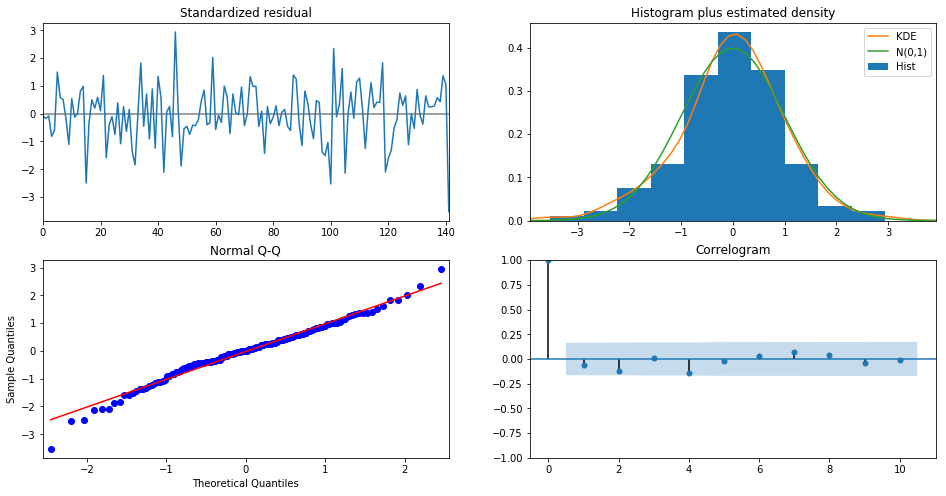

In [12]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Here we will forecast the values using the model. Can change starting point from which we need to forecast. For now we will keep starting point after 50 observations

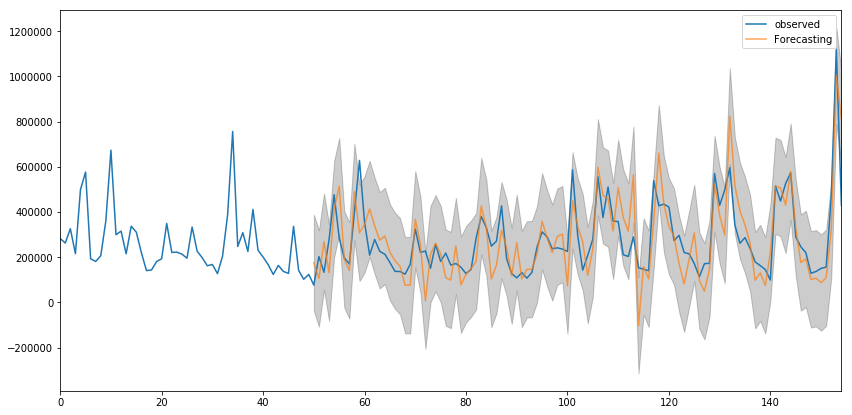

In [13]:
#Point from which prediction starts
start_point = 50
pred = results.get_prediction(start=start_point, dynamic=False)
pred_ci = pred.conf_int()
ax = sales['Sum of Sales'].plot(label='observed',)
pred.predicted_mean.plot(ax=ax, label='Forecasting', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

# Model Evaluation
 - Mean Absolute Percentage Error
 - Mean Absolute Error
 - BIAS
 - Mean Squared Error
 - Root Mean Squared Error

In [29]:
me.evaluate_model(predictions,actual)

			Model Performance

Mean Absolute Percentage Error0.3560106661188843

Mean Absolute Error 84610.80846783008

BIAS: 196.80214295822995

Mean Squared Error 4066763.764659915

Root Mean Squared Error 2016.6218695283246
